# Smooth for each level of categorical variable

To smooth for each level of a categorical variable, there are two primary methods:

1. Using a categorical by variable
2. Using the [`RandomWigglyCurve`][pymgcv.basis_functions.RandomWigglyCurve] basis function

This example shows both methods. First, we perform the imports and create a toy dataset 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymgcv.basis_functions import RandomWigglyCurve
from pymgcv.gam import GAM
from pymgcv.plot import plot_continuous_1d, plot_categorical
from pymgcv.terms import Linear as L
from pymgcv.terms import Smooth as S

rng = np.random.default_rng(0)
x = rng.uniform(-1, 1, size=200)
group = pd.Series(rng.choice(["A", "B", "C"], size=len(x)), dtype="category")

y = rng.normal(scale=0.1, size=len(x))
y[group == "A"] += np.sin(x * 2)[group == "A"]
y[group == "B"] += (x**2)[group == "B"] + 1 
y[group == "C"] += -(x**2)[group == "C"] - 1 
data = pd.DataFrame({"x": x, "y": y, "group": group})


#### Option 1: Categorical by variables:
`S("x", by="group")` can be used to fit a seperate smooth for each level of the factor, (or analagously with [`TensorSmooth`][pymgcv.terms.TensorSmooth]):

- Such smooths are centered, so we generally must include the categorical variable as a linear term too, i.e. `L("group")`.
- If the intercept is left in the model, the partial effect of the first level `L("group")` will be fixed to zero mean/variance to avoid non-identifiability with the intercept term.
- Alternativly, we can remove the intercept, in which case all levels of the linear term will have non-zero effects. Below we use this approach by setting ``add_intercepts=False`` .


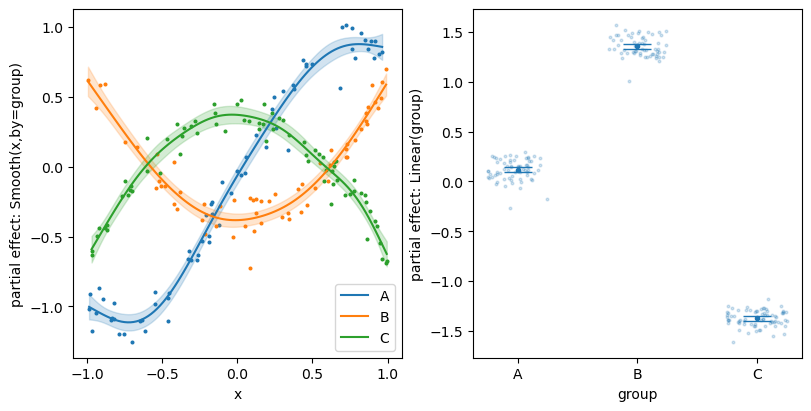

In [13]:
gam = GAM({"y": S("x", by="group") + L("group")}, add_intercepts=False)
fit = gam.fit(data)
fig, axes = plt.subplots(ncols=2, layout="constrained", figsize=(8, 4))

for by_val in ["A", "B", "C"]:
    axes[0] = plot_continuous_1d(
        target="y",
        term=S("x", by="group"),
        data=data,
        gam=fit,
        by_val=by_val,
        ax=axes[0],
        plot_kwargs={"label": by_val},
    )
axes[0].legend(loc="lower right")

plot_categorical(
    target="y",
    term=L("group"),
    data=data,
    gam=fit,
    ax=axes[1],
)
plt.show()

#### Option 2: Random wiggly curves
In contrast random wiggly curves:

1. Share a smoothing parameter
2. Are non-centered
3. Penalize the null space components (e.g. including intercepts), so can be used with an intercept term in the model without introducing any indeterminacy

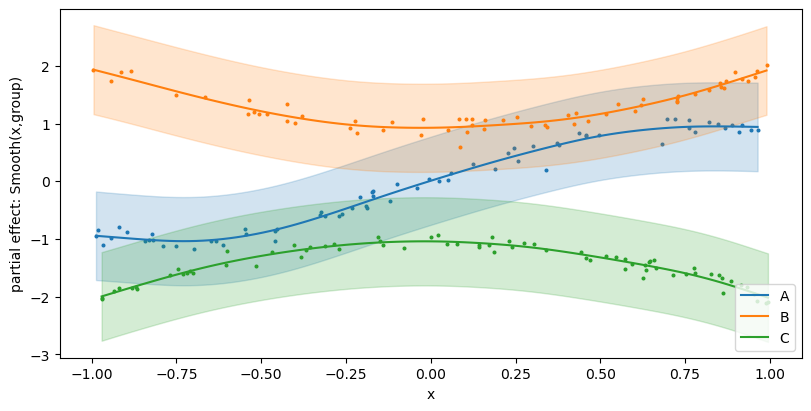

In [9]:
gam = GAM({"y": S("x", "group", bs=RandomWigglyCurve(), k=20)})
fit = gam.fit(data)
fig, axes = plt.subplots(layout="constrained", figsize=(8, 4))

for by_val in ["A", "B", "C"]:
    axes = plot_continuous_1d(
        target="y",
        term=gam.predictors["y"][0],
        data=data,
        gam=fit,
        by_val=by_val,
        ax=axes,
        plot_kwargs={"label": by_val},
    )
axes.legend(loc="lower right")
plt.show()